# UCLA Scandinavian DH Seminar, November 2017

Notebook to perform text similarity calculation and clustering for seminar hackathon.

Initial work by Matthew Wilkens, November 2017.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from   nltk.corpus.reader.plaintext import PlaintextCorpusReader
from   nltk.corpus import stopwords
from   nltk.probability import FreqDist
import gensim
from   gensim.models import Phrases
from   gensim.models import LdaModel
from   gensim.corpora import Dictionary
import pyLDAvis.gensim
from   collections import defaultdict
import operator
from   sklearn.cluster import KMeans, DBSCAN
from   sklearn.decomposition import PCA
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics import silhouette_samples, silhouette_score
from   sklearn.metrics.pairwise import pairwise_distances
from   sklearn.preprocessing import StandardScaler
from   IPython.display import display

In [2]:
%matplotlib inline

corpus_name  = 'ADL'
figDir       = 'figures'
resultsDir   = 'results'
dataDir      = os.path.join('..', '..', corpus_name)
metadataFile = os.path.join(dataDir, 'metadata', 'metadata_adl.csv')
corpusDir    = os.path.join(dataDir, 'plain')

sns.set()
sns.set_context('notebook')
plt.rc('figure', figsize=(12, 8))

pd.options.mode.chained_assignment = None # Disable warning re: setting value on slice of dataframe

## Prepare data

Can skip if just importing finished work below.

### Read metadata and examine

In [3]:
metadata = pd.read_csv(metadataFile, index_col='file_id')
display(metadata.head())
display(metadata.describe())

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
hjort_02_workid54087                Knud Hjortø   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
hjort_02_workid54087                                 Kraft   

                                            volume  birth  death  
file_id                                                           
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872  
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905  
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872  
plough01_workid56672                 SAMLEDE DIGTE   1813   1894  
hjort_02_workid54087                         KRAFT   1869   1931

birth        death
count  8787.000000  8787.000000
mean   1785.979060  1849.617048
std      89.231021    87.095092
min       0.000000     0.000000
25%    1764.000000  1826.000000
50%    1800.000000  1872.000000
75%    1863.000000  1914.000000
max    1912.000000  1938.000000

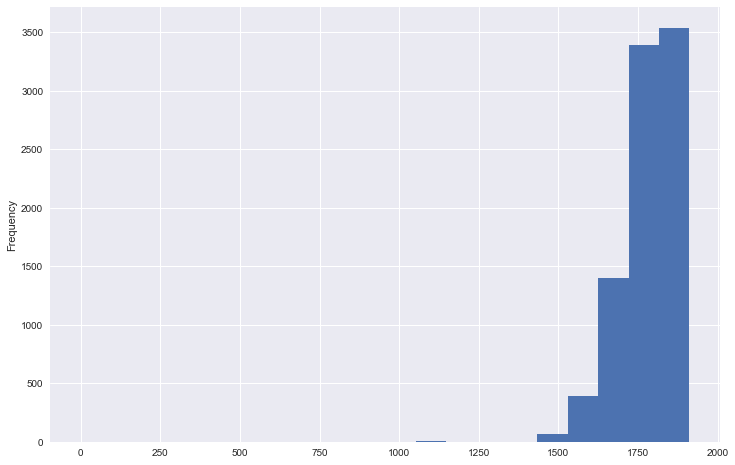

In [4]:
fig = metadata.birth.plot.hist(bins=20)

There's an oddball entry with birth and death dates == 0. Discard this one, assign a new metadata frame, and replot.

author       title       volume  birth  death
file_id                                                               
larsenk_09_workid54089  kapitel  Lægemidler  DOMMENS DAG      0      0

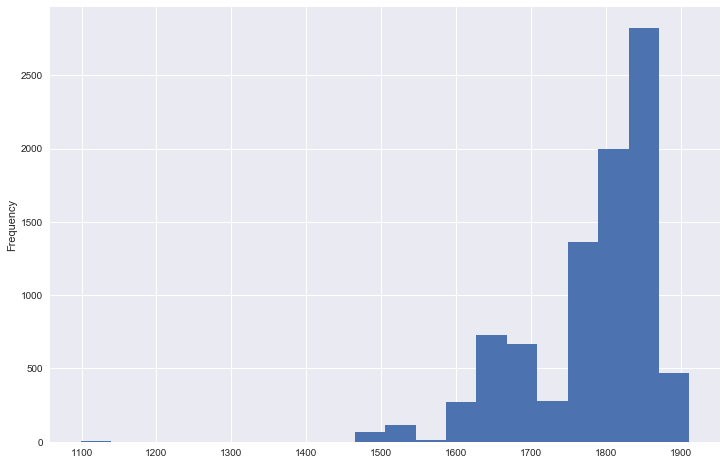

In [5]:
display(metadata[metadata.birth == 0])
md = metadata[metadata.birth != 0]
fig = md.birth.plot.hist(bins=20)

In [6]:
print("Unique authors in corpus:", md.author.nunique())
print("Unique volumes in corpus:", md.volume.nunique())
print("Total texts in coprus:", md.title.count())

Unique authors in corpus: 75
Unique volumes in corpus: 299
Total texts in coprus: 8724


### Get wordcounts and examine

This work is redundant with document processing used for topic modeling and common word features below. But it was a quick way to explore the corpus up front and I used it to select documents that were of reasonably consistent length (hence, maybe, of more consistent type; no novels, no super-short poems, etc.).

In [13]:
nltk_corpus = PlaintextCorpusReader(corpusDir, r'.*\.txt')
nltk_corpus.fileids()[:5]

['Lars_workid54234.txt',
 'Lars_workid60226.txt',
 'Lars_workid63000.txt',
 'aakjaer01val_workid100074.txt',
 'aakjaer01val_workid100247.txt']

In [14]:
md[md.index == 'Lars_workid54234']

author                  title  \
file_id                                                 
Lars_workid54234   Karl Larsen  Udenfor rangklasserne   

                                   volume  birth  death  
file_id                                                  
Lars_workid54234  Københavnerfortællinger   1860   1931

In [15]:
len(nltk_corpus.words('Lars_workid54234.txt'))

35021

Get wordcounts for all texts in corpus and append new column to metadata frame

In [16]:
wordcounts = {}
for fileid in nltk_corpus.fileids():
    wordcounts[fileid.strip('.txt')] = len(nltk_corpus.words(fileid))
md = md.join(pd.Series(wordcounts, name='wordcount'))
display(md.head())

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
hjort_02_workid54087                Knud Hjortø   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
hjort_02_workid54087                                 Kraft   

                                            volume  birth  death  wordcount  
file_id                                                                      
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0  
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0  
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0  
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0  
hjort_02_workid54087                         KRAFT   1869   1931    66532.0

Here's why wordcount column is type `float` rather than `int`: null values ...

In [17]:
md[md.wordcount.isnull()].count()

author       30
title        22
volume       30
birth        30
death        30
wordcount     0
dtype: int64

Examine the longest texts ...

author  \
file_id                                            
saxoval_workid54112                         Saxo   
bergsoev01ny_workid54112         Vilhelm Bergsøe   
grundtvig06val_workid54333      N.F.S. Grundtvig   
ingemann02_workid54477             B.S. Ingemann   
kierkegaard03val_workid54108   Søren Kierkegaard   

                                                                       title  \
file_id                                                                        
saxoval_workid54112                                Fra piazza del popolo · i   
bergsoev01ny_workid54112                           Fra piazza del popolo · i   
grundtvig06val_workid54333    Hovedstrømninger. reaktionen i frankrig (1874)   
ingemann02_workid54477                                        Valdemar seier   
kierkegaard03val_workid54108                      'at være eller ikke være.'   

                                                                         volume  \
file_id                                                                           
saxoval_workid54112                                      Saxos Danmarkshistorie   
bergsoev01ny_workid54112      Fra Piazza del Popolo · I-III<lb xml:id="idm13...   
grundtvig06val_workid54333                                    UDVALGTE SKRIFTER   
ingemann02_workid54477                                           Valdemar Seier   
kierkegaard03val_workid54108                        Dagbøger i udvalg 1834-1846   

                              birth  death  wordcount  
file_id                                                
saxoval_workid54112            1132   1208   389825.0  
bergsoev01ny_workid54112       1835   1911   298784.0  
grundtvig06val_workid54333     1783   1872   251453.0  
ingemann02_workid54477         1789   1862   215963.0  
kierkegaard03val_workid54108   1813   1855   212275.0

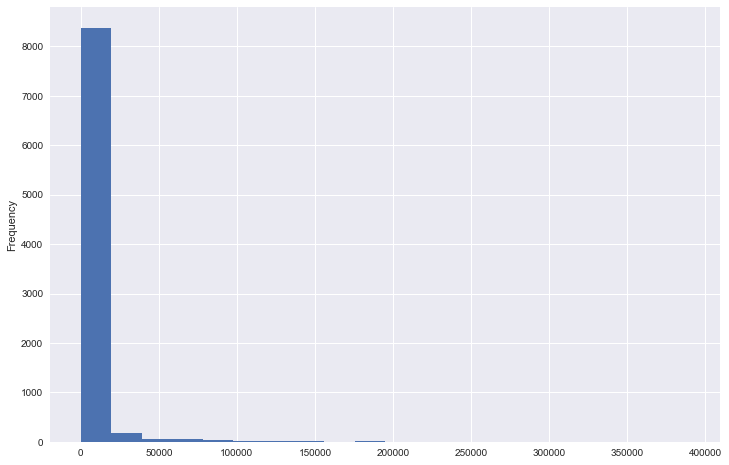

In [19]:
display(md[md.wordcount > 100000].sort_values('wordcount', ascending=False).head())
fig = md.wordcount.plot.hist(bins=20)

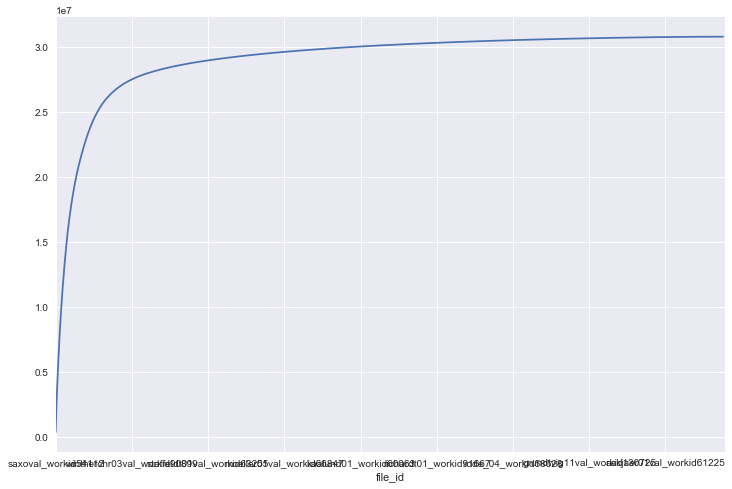

In [20]:
# Plot cumulative sum of wordcounts by volume
fig = md.wordcount.sort_values(ascending=False).cumsum().plot()

How many texts are longer than 10,000 words?

In [21]:
md[md.wordcount >= 10000].wordcount.count()

568

Define our workset as those texts with length between 100 and 10,000 words. Display descriptive stats and plot histogram of lengths.

birth       death    wordcount
count  6837.000000  6837.00000  6837.000000
mean   1782.158842  1846.98669   805.230657
std      84.719538    83.77847  1356.886230
min    1485.000000  1534.00000   100.000000
25%    1743.000000  1785.00000   192.000000
50%    1798.000000  1872.00000   339.000000
75%    1861.000000  1908.00000   722.000000
max    1912.000000  1938.00000  9999.000000

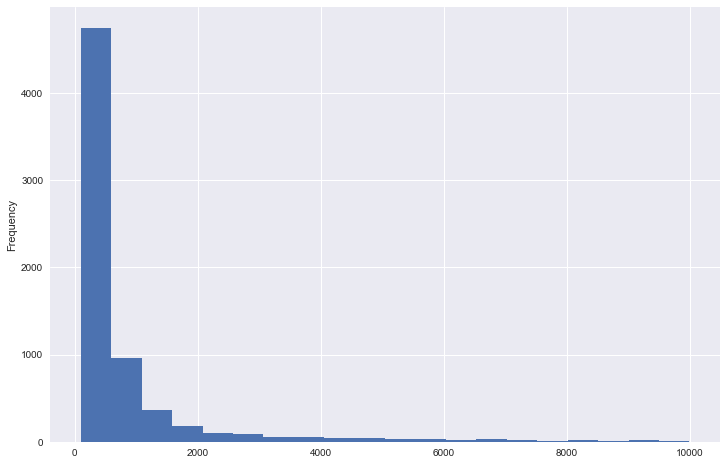

In [22]:
ws = md[md.wordcount.between(100,10000)]
display(ws.describe())
fig = ws.wordcount.plot.hist(bins=20)

In [23]:
print("Total volumes with wordcount > 100 =", md.wordcount.count(), 
      "containing", md.wordcount.sum(), "words")
print("Total volumes in restricted workset = ", ws.wordcount.count(), 
      "containing", ws.wordcount.sum(), "words")

Total volumes with wordcount > 100 = 8756 containing 30820704.0 words
Total volumes in restricted workset =  6837 containing 5505362.0 words


We currently throw out long documents (over 10k), since they're likely very different from most in the corpus. But know that that throws away most of the text (31M -> 5.5M words). Something to examine if continuing work in the future.

Finally, write out workset metadata for later reuse.

In [24]:
ws.to_csv(os.path.join(resultsDir, 'workset.csv'))
ws = pd.read_csv(os.path.join(resultsDir, 'workset.csv'), index_col='file_id')

## Gensim

See also https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb, from which much code below taken.

In [49]:
# Get Danish stopwords for use below
sw = set(stopwords.words('danish'))
len(sw)

94

In [50]:
pyLDAvis.enable_notebook()

In [51]:
docs = []
labels = []
for fid in ws.index:
    with open(os.path.join(corpusDir, fid+'.txt')) as f:
        txt = f.read()
    docs.append(txt)
    labels.append(fid)

In [52]:
print("Documents to process:", len(docs))

Documents to process: 6837


In [53]:
print(docs[0])

No. 196.
*)Jeg som et Barn mig glæde vil,Og sjunge i det Høie:Idag ei Sorg paa Jord er til,Som kan min Sjæl nedbøie!Idag er fattigst Betler rig!Et Paradis er Jorden mig,Guds Engle til mig kvæde:Idag er dig en Frelser fød!Idag al Jordens Sorg er død,Og født al Jordens Glæde!Ei Synd og Død i Verden meerMig knuge skal og kyse:Jeg Naadens Sol oprundet seer,Og den skal evig lyse!En Konge er idag mig fød:Det lidet Barn paa Moders SkiødAl Verdens Nød betvinger!Hans Rige Himmel er og Jord;*)
                        Ingemanns Jule-Sang
med et Par Smaa-Ændringer.Den Konge evig Tro jeg svor,Og Han min Sjæl gav Vinger!Flyv høit, min Sjæl, da barnefro!Forlyst dig i Hans Rige,Med Kiærlighed, med Haab og Tro!Hans Ord skal aldrig svige!I Klude svøbt, i Krybbe lagt,Det Barn har over Stormen Magt,Og over Havets Bølger;Ei Jord, ei
                           Luft
, ei
                           Ild
, ei Vand,Ei Mørkets Magter skade kanDen Sjæl, som Barnet følger!Ei Verdens Glands og Klogskab meerForblinde

In [54]:
# Tokenize, converting to lowercase
#  Also, remove line breaks, numbers, and one-letter words

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Get length of tokenized example doc for comaprison
print(len(docs[0]))

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
docs_tokenized = docs # Save tokenized, lowercase text for later use

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

273


In [41]:
docs_tokenized[0][:5]

['no', 'jeg', 'som', 'et', 'barn']

In [42]:
# Remove stopwords
docs = [[token for token in doc if token not in sw] for doc in docs]
print(len(docs[0]))

182


In [43]:
%%time
# Stem. Would like to lemmatuze, but no Danish support
from nltk.stem.snowball import DanishStemmer

# Lemmatize all words in documents.
stemmer = DanishStemmer()
docs = [[stemmer.stem(token) for token in doc] for doc in docs]

print(len(docs[0]))

182
CPU times: user 29.6 s, sys: 83.2 ms, total: 29.7 s
Wall time: 29.8 s


In [44]:
# Compute bigrams.
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [45]:
len(docs[0])

184

In [46]:
# Remove rare and common tokens.
# B/c we remove common tokens, no need for explicit list of stopwords.
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in fewer than 5 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.3)

In [47]:
len(docs[0])

184

In [48]:
# Vectorize data.
# Bag-of-words representation of the documents.
gs_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [49]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(gs_corpus))

Number of unique tokens: 23610
Number of documents: 6837


In [50]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [51]:
# Train LDA model.
# Set training parameters.
num_topics   = 100
chunksize    = 10000 # Do everything at once
passes       = 40    # 100 passes = 45-60 min.
iterations   = 400
eval_every   = None  # Don't evaluate model perplexity, takes too much time.
random_state = 4365

# Make an index-to-word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [98]:
%time model = LdaModel(corpus=gs_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=random_state, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

2017-11-10 18:49:03,485 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2017-11-10 18:49:03,492 : INFO : using serial LDA version on this node
2017-11-10 18:49:17,327 : INFO : running online (multi-pass) LDA training, 100 topics, 40 passes over the supplied corpus of 6837 documents, updating model once every 6837 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence 

2017-11-10 18:52:23,906 : INFO : topic #43 (0.009): 0.030*"ded" + 0.011*"hannem" + 0.011*"svart" + 0.011*"eder" + 0.010*"advocat" + 0.009*"grev" + 0.008*"mt" + 0.007*"sagd" + 0.007*"skuld" + 0.007*"vær"
2017-11-10 18:52:23,909 : INFO : topic #55 (0.009): 0.009*"dend" + 0.008*"ey" + 0.005*"kong" + 0.005*"kand" + 0.005*"prof" + 0.004*"hæd" + 0.004*"naad" + 0.004*"æreskal" + 0.004*"udi" + 0.004*"konning"
2017-11-10 18:52:23,911 : INFO : topic #61 (0.010): 0.006*"ei" + 0.004*"see" + 0.004*"saae" + 0.004*"gik" + 0.003*"stod" + 0.003*"lang" + 0.003*"kund" + 0.003*"ven" + 0.003*"stil" + 0.003*"sagd"
2017-11-10 18:52:23,914 : INFO : topic #8 (0.010): 0.009*"sagd" + 0.006*"gik" + 0.006*"kund" + 0.005*"skuld" + 0.004*"hen" + 0.004*"sam" + 0.004*"stod" + 0.004*"gang" + 0.004*"ogsaa" + 0.004*"sig"
2017-11-10 18:52:23,917 : INFO : topic #0 (0.011): 0.007*"ej" + 0.005*"men" + 0.005*"hjert" + 0.004*"lys" + 0.004*"sang" + 0.004*"ei" + 0.004*"bølg" + 0.003*"gaml" + 0.003*"frem" + 0.003*"nat"
2017-11-10

2017-11-10 18:53:56,092 : INFO : topic #44 (0.009): 0.007*"himl" + 0.005*"suk" + 0.005*"hvorfor" + 0.004*"engl" + 0.004*"see" + 0.004*"sol" + 0.004*"mørk" + 0.004*"jomfru" + 0.004*"lyst" + 0.004*"skiul"
2017-11-10 18:53:56,094 : INFO : topic #55 (0.009): 0.009*"prof" + 0.008*"ey" + 0.007*"dend" + 0.006*"æreskal" + 0.006*"hæd" + 0.005*"kong" + 0.005*"naad" + 0.005*"konning" + 0.004*"claus" + 0.004*"kand"
2017-11-10 18:53:56,096 : INFO : topic #42 (0.011): 0.023*"ei" + 0.010*"hjert" + 0.008*"ak" + 0.005*"sang" + 0.005*"sød" + 0.005*"glæd" + 0.005*"bryst" + 0.005*"evig" + 0.005*"elsk" + 0.005*"ros"
2017-11-10 18:53:56,099 : INFO : topic #62 (0.013): 0.011*"sol" + 0.008*"ej" + 0.007*"gaar" + 0.006*"sang" + 0.005*"staar" + 0.005*"se" + 0.005*"drøm" + 0.005*"hvid" + 0.004*"nat" + 0.004*"lys"
2017-11-10 18:53:56,101 : INFO : topic #0 (0.014): 0.009*"ej" + 0.005*"hjert" + 0.005*"lys" + 0.005*"men" + 0.004*"sang" + 0.004*"bølg" + 0.004*"gaml" + 0.004*"hav" + 0.004*"danmark" + 0.004*"frem"
2017-

2017-11-10 18:55:23,398 : INFO : topic #55 (0.008): 0.011*"prof" + 0.007*"ey" + 0.007*"æreskal" + 0.006*"hæd" + 0.005*"naad" + 0.005*"konning" + 0.005*"kong" + 0.004*"claus" + 0.004*"dend" + 0.004*"rig"
2017-11-10 18:55:23,400 : INFO : topic #44 (0.008): 0.006*"himl" + 0.005*"suk" + 0.005*"hvorfor" + 0.004*"see" + 0.004*"mørk" + 0.004*"engl" + 0.004*"skiul" + 0.004*"sol" + 0.004*"vær_velkom" + 0.004*"lyst"
2017-11-10 18:55:23,402 : INFO : topic #42 (0.013): 0.023*"ei" + 0.010*"hjert" + 0.008*"ak" + 0.006*"sang" + 0.005*"glæd" + 0.005*"bryst" + 0.005*"sød" + 0.005*"evig" + 0.005*"elsk" + 0.005*"taar"
2017-11-10 18:55:23,404 : INFO : topic #62 (0.015): 0.011*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.005*"se" + 0.005*"drøm" + 0.005*"hvid" + 0.005*"lys" + 0.005*"men" + 0.005*"sang"
2017-11-10 18:55:23,407 : INFO : topic #0 (0.016): 0.010*"ej" + 0.005*"hjert" + 0.004*"lys" + 0.004*"men" + 0.004*"danmark" + 0.004*"sang" + 0.004*"gaml" + 0.004*"bølg" + 0.004*"hav" + 0.004*"land"
2

2017-11-10 18:56:47,019 : INFO : topic #44 (0.008): 0.005*"himl" + 0.005*"hvorfor" + 0.005*"suk" + 0.004*"see" + 0.004*"vær_velkom" + 0.004*"mørk" + 0.004*"portræt" + 0.004*"skiul" + 0.004*"engl" + 0.003*"lyst"
2017-11-10 18:56:47,022 : INFO : topic #9 (0.008): 0.009*"væv" + 0.009*"lil" + 0.008*"god" + 0.007*"perl" + 0.006*"velkom" + 0.005*"christian" + 0.005*"hjert" + 0.005*"bald" + 0.005*"elsk" + 0.004*"lov"
2017-11-10 18:56:47,024 : INFO : topic #42 (0.014): 0.023*"ei" + 0.009*"hjert" + 0.009*"ak" + 0.006*"glæd" + 0.006*"bryst" + 0.006*"sang" + 0.005*"evig" + 0.005*"taar" + 0.005*"elsk" + 0.005*"sød"
2017-11-10 18:56:47,027 : INFO : topic #62 (0.018): 0.011*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.005*"se" + 0.005*"lys" + 0.005*"men" + 0.005*"hvid" + 0.005*"drøm" + 0.005*"nat"
2017-11-10 18:56:47,029 : INFO : topic #0 (0.019): 0.011*"ej" + 0.005*"hjert" + 0.005*"danmark" + 0.004*"lys" + 0.004*"gaml" + 0.004*"sang" + 0.004*"men" + 0.004*"land" + 0.004*"bølg" + 0.004*"hav

2017-11-10 18:58:11,761 : INFO : topic #55 (0.008): 0.013*"prof" + 0.008*"æreskal" + 0.007*"hæd" + 0.005*"konning" + 0.005*"ey" + 0.005*"naad" + 0.004*"esau" + 0.004*"kong" + 0.004*"god" + 0.003*"rig"
2017-11-10 18:58:11,764 : INFO : topic #44 (0.008): 0.005*"hvorfor" + 0.005*"himl" + 0.004*"suk" + 0.004*"vær_velkom" + 0.004*"see" + 0.004*"portræt" + 0.004*"mørk" + 0.004*"skiul" + 0.003*"lyst" + 0.003*"mand"
2017-11-10 18:58:11,767 : INFO : topic #42 (0.015): 0.022*"ei" + 0.009*"ak" + 0.009*"hjert" + 0.006*"glæd" + 0.006*"bryst" + 0.006*"evig" + 0.006*"sang" + 0.006*"taar" + 0.005*"elsk" + 0.005*"sød"
2017-11-10 18:58:11,770 : INFO : topic #0 (0.021): 0.011*"ej" + 0.005*"hjert" + 0.005*"danmark" + 0.004*"gaml" + 0.004*"lys" + 0.004*"land" + 0.004*"sang" + 0.004*"men" + 0.004*"frem" + 0.004*"hav"
2017-11-10 18:58:11,772 : INFO : topic #62 (0.021): 0.011*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.005*"lys" + 0.005*"se" + 0.005*"men" + 0.005*"hvid" + 0.005*"drøm" + 0.005*"nat"


2017-11-10 18:59:40,984 : INFO : topic #44 (0.008): 0.004*"hvorfor" + 0.004*"vær_velkom" + 0.004*"suk" + 0.004*"himl" + 0.004*"see" + 0.004*"portræt" + 0.004*"mørk" + 0.003*"skiul" + 0.003*"lyst" + 0.003*"mand"
2017-11-10 18:59:40,986 : INFO : topic #55 (0.008): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"naad" + 0.004*"god" + 0.004*"ey" + 0.003*"kald" + 0.003*"kong"
2017-11-10 18:59:40,988 : INFO : topic #42 (0.017): 0.022*"ei" + 0.009*"ak" + 0.008*"hjert" + 0.006*"glæd" + 0.006*"bryst" + 0.006*"evig" + 0.006*"sang" + 0.006*"taar" + 0.005*"elsk" + 0.005*"sød"
2017-11-10 18:59:40,990 : INFO : topic #0 (0.024): 0.012*"ej" + 0.005*"hjert" + 0.005*"danmark" + 0.004*"gaml" + 0.004*"land" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"men" + 0.004*"hav"
2017-11-10 18:59:40,993 : INFO : topic #62 (0.024): 0.011*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.005*"lys" + 0.005*"men" + 0.005*"se" + 0.005*"hvid" + 0.005*"nat" + 0.005*"drøm"

2017-11-10 19:01:08,193 : INFO : topic #44 (0.007): 0.004*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"see" + 0.004*"himl" + 0.003*"mørk" + 0.003*"mand" + 0.003*"lyst" + 0.003*"skiul"
2017-11-10 19:01:08,195 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"naad" + 0.004*"god" + 0.003*"kald" + 0.003*"glad" + 0.003*"rig"
2017-11-10 19:01:08,197 : INFO : topic #42 (0.018): 0.021*"ei" + 0.009*"ak" + 0.008*"hjert" + 0.006*"glæd" + 0.006*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"sang" + 0.006*"elsk" + 0.005*"sød"
2017-11-10 19:01:08,199 : INFO : topic #0 (0.026): 0.012*"ej" + 0.005*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.004*"land" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"vort" + 0.004*"men"
2017-11-10 19:01:08,202 : INFO : topic #62 (0.028): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"se" + 0.005*"hvid" + 0.005*"nat" + 0.005*"drø

2017-11-10 19:02:34,336 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"god" + 0.003*"naad" + 0.003*"kald" + 0.003*"glad" + 0.003*"brød"
2017-11-10 19:02:34,341 : INFO : topic #44 (0.007): 0.005*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"see" + 0.004*"himl" + 0.003*"mand" + 0.003*"lyst" + 0.003*"mørk" + 0.003*"skiul"
2017-11-10 19:02:34,343 : INFO : topic #42 (0.019): 0.021*"ei" + 0.009*"ak" + 0.008*"hjert" + 0.006*"glæd" + 0.006*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"sang" + 0.006*"elsk" + 0.005*"himl"
2017-11-10 19:02:34,346 : INFO : topic #0 (0.028): 0.012*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"vort" + 0.004*"men"
2017-11-10 19:02:34,352 : INFO : topic #62 (0.031): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"se" + 0.005*"hvid" + 0.005*"nat" + 0.005*"d

2017-11-10 19:04:01,291 : INFO : topic #44 (0.007): 0.005*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"see" + 0.004*"mand" + 0.003*"lyst" + 0.003*"himl" + 0.003*"mørk" + 0.003*"skiul"
2017-11-10 19:04:01,294 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"god" + 0.003*"kald" + 0.003*"naad" + 0.003*"glad" + 0.003*"ven"
2017-11-10 19:04:01,297 : INFO : topic #42 (0.020): 0.021*"ei" + 0.009*"ak" + 0.008*"hjert" + 0.007*"glæd" + 0.006*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"sang" + 0.006*"elsk" + 0.005*"himl"
2017-11-10 19:04:01,299 : INFO : topic #0 (0.030): 0.013*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"lys" + 0.004*"sang" + 0.004*"vort" + 0.004*"frem" + 0.004*"men"
2017-11-10 19:04:01,302 : INFO : topic #62 (0.034): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"se" + 0.005*"nat" + 0.005*"hvid" + 0.005*"dr

2017-11-10 19:05:29,634 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"god" + 0.003*"kald" + 0.003*"glad" + 0.003*"naad" + 0.003*"ven"
2017-11-10 19:05:29,636 : INFO : topic #44 (0.007): 0.005*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"see" + 0.004*"mand" + 0.003*"lyst" + 0.003*"himl" + 0.003*"skiul" + 0.003*"mørk"
2017-11-10 19:05:29,639 : INFO : topic #42 (0.022): 0.020*"ei" + 0.009*"ak" + 0.007*"hjert" + 0.007*"glæd" + 0.006*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"sang" + 0.006*"elsk" + 0.005*"himl"
2017-11-10 19:05:29,642 : INFO : topic #0 (0.032): 0.013*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"lys" + 0.004*"vort" + 0.004*"sang" + 0.004*"frem" + 0.004*"men"
2017-11-10 19:05:29,644 : INFO : topic #62 (0.037): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"nat" + 0.005*"se" + 0.005*"hvid" + 0.005*"dr

2017-11-10 19:06:52,008 : INFO : topic #44 (0.007): 0.004*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"mand" + 0.004*"see" + 0.003*"lyst" + 0.003*"skiul" + 0.003*"himl" + 0.003*"mørk"
2017-11-10 19:06:52,010 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"god" + 0.003*"kald" + 0.003*"glad" + 0.003*"ven" + 0.003*"lyst"
2017-11-10 19:06:52,013 : INFO : topic #42 (0.023): 0.020*"ei" + 0.009*"ak" + 0.007*"hjert" + 0.007*"glæd" + 0.007*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"elsk" + 0.006*"sang" + 0.005*"himl"
2017-11-10 19:06:52,015 : INFO : topic #0 (0.034): 0.013*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"vort" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"men"
2017-11-10 19:06:52,018 : INFO : topic #62 (0.040): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"nat" + 0.005*"se" + 0.005*"hvid" + 0.005*"dr

2017-11-10 19:08:14,065 : INFO : topic #44 (0.007): 0.004*"vær_velkom" + 0.004*"hvorfor" + 0.004*"suk" + 0.004*"portræt" + 0.004*"mand" + 0.004*"see" + 0.003*"lyst" + 0.003*"skiul" + 0.003*"himl" + 0.003*"veed"
2017-11-10 19:08:14,067 : INFO : topic #55 (0.007): 0.013*"prof" + 0.008*"æreskal" + 0.006*"hæd" + 0.005*"konning" + 0.004*"esau" + 0.004*"god" + 0.003*"kald" + 0.003*"glad" + 0.003*"ven" + 0.003*"lyst"
2017-11-10 19:08:14,070 : INFO : topic #42 (0.024): 0.020*"ei" + 0.009*"ak" + 0.007*"hjert" + 0.007*"glæd" + 0.007*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"elsk" + 0.006*"sang" + 0.005*"himl"
2017-11-10 19:08:14,073 : INFO : topic #0 (0.036): 0.013*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"vort" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"men"
2017-11-10 19:08:14,076 : INFO : topic #62 (0.042): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"nat" + 0.005*"se" + 0.005*"hvid" + 0.005*"dr

2017-11-10 19:09:46,037 : INFO : topic #44 (0.007): 0.004*"vær_velkom" + 0.004*"hvorfor" + 0.004*"portræt" + 0.004*"suk" + 0.004*"mand" + 0.004*"see" + 0.003*"lyst" + 0.003*"skiul" + 0.003*"veed" + 0.003*"himl"
2017-11-10 19:09:46,039 : INFO : topic #49 (0.007): 0.006*"andr" + 0.006*"perl" + 0.005*"kost" + 0.005*"kund" + 0.005*"haleluja" + 0.004*"endnu" + 0.004*"skuld" + 0.004*"politik" + 0.004*"int" + 0.004*"dyrebar"
2017-11-10 19:09:46,045 : INFO : topic #42 (0.025): 0.020*"ei" + 0.009*"ak" + 0.007*"hjert" + 0.007*"glæd" + 0.007*"evig" + 0.006*"bryst" + 0.006*"taar" + 0.006*"elsk" + 0.006*"sang" + 0.005*"himl"
2017-11-10 19:09:46,055 : INFO : topic #0 (0.038): 0.013*"ej" + 0.006*"danmark" + 0.005*"hjert" + 0.005*"gaml" + 0.005*"land" + 0.004*"vort" + 0.004*"lys" + 0.004*"sang" + 0.004*"frem" + 0.004*"men"
2017-11-10 19:09:46,060 : INFO : topic #62 (0.045): 0.010*"sol" + 0.009*"ej" + 0.007*"gaar" + 0.006*"staar" + 0.006*"lys" + 0.005*"men" + 0.005*"nat" + 0.005*"hvid" + 0.005*"se" + 0

CPU times: user 20min 26s, sys: 28.2 s, total: 20min 55s
Wall time: 21min 10s


In [52]:
logging.disable(logging.INFO)

In [104]:
model.save(os.path.join(resultsDir, 'adl-topics-100'))

In [53]:
model = LdaModel.load(os.path.join(resultsDir, 'adl-topics-100'))

In [54]:
top_topics = model.top_topics(gs_corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -2.1477.
[([(0.0071719890881911524, 'mennesk'),
   (0.0062538451786695055, 'mer'),
   (0.0059493622106257804, 'uden'),
   (0.0057284082251628102, 'giv'),
   (0.0053343714076283591, 'andr'),
   (0.0052988481525753518, 'ere'),
   (0.0050784463766953333, 'vis'),
   (0.0047238642845697258, 'folk'),
   (0.0046273042573502666, 'kund'),
   (0.0046245049729856866, 'find'),
   (0.004576084376808189, 'ogsaa'),
   (0.0043365078417038688, 'virk'),
   (0.0043336510946677545, 'hvilk'),
   (0.0042867274911963871, 'blot'),
   (0.0041986874124844845, 'ret'),
   (0.0040802598560937611, 'sand'),
   (0.0040293644779620741, 'sam'),
   (0.0039334107078547046, 'saadan'),
   (0.0037025238872580267, 'føl'),
   (0.003676217757539913, 'tal')],
  -0.87899303890031943),
 ([(0.0063565565313701416, 'ogsaa'),
   (0.0062914037661410344, 'sig'),
   (0.0059374260630716902, 'kund'),
   (0.0057368740355414893, 'see'),
   (0.0052672700426116895, 'een'),
   (0.0052387233467810629, 'først'),
   (0.00

   (0.0049224413162067921, 'må'),
   (0.0045032366041138326, 'tank'),
   (0.0042052103594243575, 'brud'),
   (0.0040881261533982681, 'ret'),
   (0.0039973022630046514, 'sind'),
   (0.0039758650991909873, 'salm'),
   (0.0038010421490315052, 'tal'),
   (0.0036375013446892351, 'dvs')],
  -1.3687090516340774),
 ([(0.0071098832908948742, 'natur'),
   (0.0066126081338466463, 'skjøn'),
   (0.0059689605965811835, 'kjær'),
   (0.0054457513365531521, 'tank'),
   (0.005217755001852651, 'den'),
   (0.0050990776704069084, 'ven'),
   (0.0049708146699953999, 'sjæl'),
   (0.0049371633517105327, 'hjert'),
   (0.0042570873872593016, 'tal'),
   (0.0042048121584947074, 'sang'),
   (0.0041909344426943832, 'digt'),
   (0.0037777824062131811, 'att'),
   (0.0036386614406240755, 'ei'),
   (0.0035967452197394542, 'hjem'),
   (0.0035398705054471582, 'gaml'),
   (0.003274441618676197, 'mennesk'),
   (0.0031744329623885573, 'kunst'),
   (0.0030680265856595757, 'billed'),
   (0.0030204563693131104, 'stil'),
   (0.0

In [55]:
vis = pyLDAvis.gensim.prepare(model, gs_corpus, dictionary)

/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [56]:
pyLDAvis.save_html(vis, os.path.join(figDir, 'pyldavis.html'))
pyLDAvis.display(vis)

Note that topic numbers above run 1-100, whereas indices are 0-99.

In [57]:
doctopics = gensim.matutils.corpus2dense(model[gs_corpus], model.num_topics, len(gs_corpus))

In [58]:
dtdf = pd.DataFrame(np.transpose(doctopics))

In [59]:
dtdf.head()

0         1    2    3    4    5         6         7    8    9  ...   \
0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0 ...    
1  0.145204  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0 ...    
2  0.000000  0.000000  0.0  0.0  0.0  0.0  0.045400  0.153235  0.0  0.0 ...    
3  0.594013  0.025744  0.0  0.0  0.0  0.0  0.041704  0.000000  0.0  0.0 ...    
4  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0 ...    

    90   91   92   93   94   95   96        97   98   99  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.031664  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  

[5 rows x 100 columns]

In [60]:
dtdf.describe()

0            1            2            3            4   \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.090308     0.002468     0.003952     0.002656     0.012208   
std       0.193417     0.033379     0.050490     0.041608     0.069550   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.053342     0.000000     0.000000     0.000000     0.000000   
max       0.995776     0.992801     0.999354     0.998585     0.998458   

                5            6            7            8            9   \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.014527     0.006484     0.016151     0.036783     0.002533   
std       0.095775     0.043192     0.084049     0.129381     0.041085   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.998927     0.999763     0.998775     0.998861     0.994213   

          ...                90           91           92           93  \
count     ...       6837.000000  6837.000000  6837.000000  6837.000000   
mean      ...          0.002936     0.001711     0.002762     0.002431   
std       ...          0.029176     0.022238     0.040551     0.028865   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.000000     0.000000     0.000000     0.000000   
50%       ...          0.000000     0.000000     0.000000     0.000000   
75%       ...          0.000000     0.000000     0.000000     0.000000   
max       ...          0.999763     0.796694     0.995768     0.999561   

                94           95           96           97           98  \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.003756     0.005449     0.002442     0.003789     0.003527   
std       0.031836     0.044881     0.027519     0.039827     0.032932   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.939091     0.999580     0.805122     0.997025     0.810531   

                99  
count  6837.000000  
mean      0.007794  
std       0.048233  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       0.955367  

[8 rows x 100 columns]

In [61]:
dtdf['file_id'] = labels

In [62]:
dtdf.set_index('file_id', inplace=True)

In [63]:
dtdf[dtdf.index == 'grundtvig11val_workid118888'].idxmax(axis=1)

file_id
grundtvig11val_workid118888    16
dtype: int64

In [66]:
dtdf.shape

(6837, 100)

In [67]:
tm_cols = ['tm-'+str(i) for i in range(dtdf.shape[1])]
dtdf.columns = tm_cols

In [68]:
dtdf.head()

tm-0      tm-1  tm-2  tm-3  tm-4  tm-5  \
file_id                                                                   
grundtvig11val_workid118888  0.000000  0.000000   0.0   0.0   0.0   0.0   
stuckenberg02_workid77235    0.145204  0.000000   0.0   0.0   0.0   0.0   
hauch03val_workid83908       0.000000  0.000000   0.0   0.0   0.0   0.0   
plough01_workid56672         0.594013  0.025744   0.0   0.0   0.0   0.0   
claussen04val_workid58330    0.000000  0.000000   0.0   0.0   0.0   0.0   

                                 tm-6      tm-7  tm-8  tm-9  ...    tm-90  \
file_id                                                      ...            
grundtvig11val_workid118888  0.000000  0.000000   0.0   0.0  ...      0.0   
stuckenberg02_workid77235    0.000000  0.000000   0.0   0.0  ...      0.0   
hauch03val_workid83908       0.045400  0.153235   0.0   0.0  ...      0.0   
plough01_workid56672         0.041704  0.000000   0.0   0.0  ...      0.0   
claussen04val_workid58330    0.000000  0.000000   0.0   0.0  ...      0.0   

                             tm-91  tm-92  tm-93  tm-94  tm-95  tm-96  \
file_id                                                                 
grundtvig11val_workid118888    0.0    0.0    0.0    0.0    0.0    0.0   
stuckenberg02_workid77235      0.0    0.0    0.0    0.0    0.0    0.0   
hauch03val_workid83908         0.0    0.0    0.0    0.0    0.0    0.0   
plough01_workid56672           0.0    0.0    0.0    0.0    0.0    0.0   
claussen04val_workid58330      0.0    0.0    0.0    0.0    0.0    0.0   

                                tm-97  tm-98  tm-99  
file_id                                              
grundtvig11val_workid118888  0.031664    0.0    0.0  
stuckenberg02_workid77235    0.000000    0.0    0.0  
hauch03val_workid83908       0.000000    0.0    0.0  
plough01_workid56672         0.000000    0.0    0.0  
claussen04val_workid58330    0.000000    0.0    0.0  

[5 rows x 100 columns]

In [69]:
dftemp = ws.join(dtdf)
dftemp.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
claussen04val_workid58330       Sophus Claussen   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
claussen04val_workid58330                   I en frugthave   

                                            volume  birth  death  wordcount  \
file_id                                                                       
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0   
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0   
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0   
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0   
claussen04val_workid58330                 Lyrik II   1865   1931      224.0   

                                 tm-0      tm-1  tm-2  tm-3  ...    tm-90  \
file_id                                                      ...            
grundtvig11val_workid118888  0.000000  0.000000   0.0   0.0  ...      0.0   
stuckenberg02_workid77235    0.145204  0.000000   0.0   0.0  ...      0.0   
hauch03val_workid83908       0.000000  0.000000   0.0   0.0  ...      0.0   
plough01_workid56672         0.594013  0.025744   0.0   0.0  ...      0.0   
claussen04val_workid58330    0.000000  0.000000   0.0   0.0  ...      0.0   

                             tm-91  tm-92  tm-93  tm-94  tm-95  tm-96  \
file_id                                                                 
grundtvig11val_workid118888    0.0    0.0    0.0    0.0    0.0    0.0   
stuckenberg02_workid77235      0.0    0.0    0.0    0.0    0.0    0.0   
hauch03val_workid83908         0.0    0.0    0.0    0.0    0.0    0.0   
plough01_workid56672           0.0    0.0    0.0    0.0    0.0    0.0   
claussen04val_workid58330      0.0    0.0    0.0    0.0    0.0    0.0   

                                tm-97  tm-98  tm-99  
file_id                                              
grundtvig11val_workid118888  0.031664    0.0    0.0  
stuckenberg02_workid77235    0.000000    0.0    0.0  
hauch03val_workid83908       0.000000    0.0    0.0  
plough01_workid56672         0.000000    0.0    0.0  
claussen04val_workid58330    0.000000    0.0    0.0  

[5 rows x 106 columns]

In [70]:
dftemp.shape

(6837, 106)

In [71]:
dtdf.to_csv(os.path.join(resultsDir, 'topicdata.csv'))

In [70]:
dtdf = pd.read_csv(os.path.join(resultsDir, 'topicdata.csv'), index_col='file_id')

## Common words

Using NLTK on tokenized input from above.

In [55]:
# Compute word fequencies in full corpus
fdist = FreqDist()
for doc in docs_tokenized:
    for word in doc:
        fdist[word] += 1

In [56]:
fdist.most_common(100)[:5]

[('og', 162450), ('i', 97770), ('det', 73074), ('den', 63024), ('at', 61926)]

In [57]:
# Get set of top-100 words in full corpus
topn = []
for i in fdist.most_common(100):
    topn.append(i[0])

In [58]:
topn_data = []
for doc in docs_tokenized:
    topn_doc = []
    fdist_doc = FreqDist()
    for word in doc:
        fdist_doc[word] += 1
    for word in topn:
        if fdist_doc.get(word):
            topn_doc.append(fdist_doc.get(word)*1000/len(doc))
        else:
            topn_doc.append(0)
    topn_data.append(topn_doc)

In [59]:
fwdf = pd.DataFrame(topn_data)

In [60]:
fwdf.shape

(6837, 100)

In [61]:
fwdf['file_id'] = labels

In [62]:
fwdf.set_index('file_id', inplace=True)

In [63]:
fwdf.head()

0          1          2          3    4   \
file_id                                                                        
grundtvig11val_workid118888  44.117647  22.058824  14.705882  11.029412  0.0   
stuckenberg02_workid77235     8.620690  51.724138   8.620690  25.862069  0.0   
hauch03val_workid83908       33.003300  19.801980   9.900990  16.501650  0.0   
plough01_workid56672         41.666667  18.939394   7.575758  18.939394  0.0   
claussen04val_workid58330    42.780749  16.042781  16.042781   5.347594  0.0   

                                    5          6          7          8   \
file_id                                                                   
grundtvig11val_workid118888  14.705882  18.382353  11.029412  36.764706   
stuckenberg02_workid77235     0.000000   0.000000  34.482759  25.862069   
hauch03val_workid83908       56.105611   9.900990  13.201320   0.000000   
plough01_workid56672          0.000000   3.787879   7.575758  11.363636   
claussen04val_workid58330    21.390374  21.390374  10.695187  26.737968   

                                    9    ...      90        91        92   93  \
file_id                                  ...                                    
grundtvig11val_workid118888  11.029412   ...     0.0  3.676471  0.000000  0.0   
stuckenberg02_workid77235     0.000000   ...     0.0  0.000000  0.000000  0.0   
hauch03val_workid83908        0.000000   ...     0.0  3.300330  0.000000  0.0   
plough01_workid56672          7.575758   ...     0.0  0.000000  7.575758  0.0   
claussen04val_workid58330     0.000000   ...     0.0  0.000000  0.000000  0.0   

                              94   95   96       97   98       99  
file_id                                                            
grundtvig11val_workid118888  0.0  0.0  0.0  0.00000  0.0  0.00000  
stuckenberg02_workid77235    0.0  0.0  0.0  0.00000  0.0  0.00000  
hauch03val_workid83908       0.0  0.0  0.0  3.30033  0.0  3.30033  
plough01_workid56672         0.0  0.0  0.0  0.00000  0.0  0.00000  
claussen04val_workid58330    0.0  0.0  0.0  0.00000  0.0  0.00000  

[5 rows x 100 columns]

In [64]:
fw_cols = ['fw-'+word for word in topn]
fwdf.columns = fw_cols

In [65]:
fwdf.head()

fw-og       fw-i     fw-det     fw-den  \
file_id                                                                   
grundtvig11val_workid118888  44.117647  22.058824  14.705882  11.029412   
stuckenberg02_workid77235     8.620690  51.724138   8.620690  25.862069   
hauch03val_workid83908       33.003300  19.801980   9.900990  16.501650   
plough01_workid56672         41.666667  18.939394   7.575758  18.939394   
claussen04val_workid58330    42.780749  16.042781  16.042781   5.347594   

                             fw-at     fw-jeg     fw-som      fw-en  \
file_id                                                               
grundtvig11val_workid118888    0.0  14.705882  18.382353  11.029412   
stuckenberg02_workid77235      0.0   0.000000   0.000000  34.482759   
hauch03val_workid83908         0.0  56.105611   9.900990  13.201320   
plough01_workid56672           0.0   0.000000   3.787879   7.575758   
claussen04val_workid58330      0.0  21.390374  21.390374  10.695187   

                                 fw-er     fw-til   ...     fw-hende  \
file_id                                             ...                
grundtvig11val_workid118888  36.764706  11.029412   ...          0.0   
stuckenberg02_workid77235    25.862069   0.000000   ...          0.0   
hauch03val_workid83908        0.000000   0.000000   ...          0.0   
plough01_workid56672         11.363636   7.575758   ...          0.0   
claussen04val_workid58330    26.737968   0.000000   ...          0.0   

                             fw-aldrig    fw-ned  fw-ej  fw-ey  fw-gamle  \
file_id                                                                    
grundtvig11val_workid118888   3.676471  0.000000    0.0    0.0       0.0   
stuckenberg02_workid77235     0.000000  0.000000    0.0    0.0       0.0   
hauch03val_workid83908        3.300330  0.000000    0.0    0.0       0.0   
plough01_workid56672          0.000000  7.575758    0.0    0.0       0.0   
claussen04val_workid58330     0.000000  0.000000    0.0    0.0       0.0   

                             fw-have  fw-skulde  fw-lille  fw-hvis  
file_id                                                             
grundtvig11val_workid118888      0.0    0.00000       0.0  0.00000  
stuckenberg02_workid77235        0.0    0.00000       0.0  0.00000  
hauch03val_workid83908           0.0    3.30033       0.0  3.30033  
plough01_workid56672             0.0    0.00000       0.0  0.00000  
claussen04val_workid58330        0.0    0.00000       0.0  0.00000  

[5 rows x 100 columns]

In [66]:
fwdf.to_csv(os.path.join(resultsDir, 'freqworddata.csv'))

In [71]:
consolidated_data = ws.join(dtdf).join(fwdf)

In [72]:
consolidated_data.shape

(6837, 206)

In [73]:
consolidated_data.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
claussen04val_workid58330       Sophus Claussen   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
claussen04val_workid58330                   I en frugthave   

                                            volume  birth  death  wordcount  \
file_id                                                                       
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0   
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0   
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0   
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0   
claussen04val_workid58330                 Lyrik II   1865   1931      224.0   

                                 tm-0      tm-1  tm-2  tm-3   ...     \
file_id                                                       ...      
grundtvig11val_workid118888  0.000000  0.000000   0.0   0.0   ...      
stuckenberg02_workid77235    0.145204  0.000000   0.0   0.0   ...      
hauch03val_workid83908       0.000000  0.000000   0.0   0.0   ...      
plough01_workid56672         0.594013  0.025744   0.0   0.0   ...      
claussen04val_workid58330    0.000000  0.000000   0.0   0.0   ...      

                             fw-hende  fw-aldrig    fw-ned  fw-ej  fw-ey  \
file_id                                                                    
grundtvig11val_workid118888       0.0   3.676471  0.000000    0.0    0.0   
stuckenberg02_workid77235         0.0   0.000000  0.000000    0.0    0.0   
hauch03val_workid83908            0.0   3.300330  0.000000    0.0    0.0   
plough01_workid56672              0.0   0.000000  7.575758    0.0    0.0   
claussen04val_workid58330         0.0   0.000000  0.000000    0.0    0.0   

                             fw-gamle  fw-have  fw-skulde  fw-lille  fw-hvis  
file_id                                                                       
grundtvig11val_workid118888       0.0      0.0    0.00000       0.0  0.00000  
stuckenberg02_workid77235         0.0      0.0    0.00000       0.0  0.00000  
hauch03val_workid83908            0.0      0.0    3.30033       0.0  3.30033  
plough01_workid56672              0.0      0.0    0.00000       0.0  0.00000  
claussen04val_workid58330         0.0      0.0    0.00000       0.0  0.00000  

[5 rows x 206 columns]

In [74]:
consolidated_data.to_csv(os.path.join(resultsDir, 'consolidateddata.csv'))

## Read in data if not reproducing from texts

In [75]:
source_data = pd.read_csv(os.path.join(resultsDir, 'consolidateddata.csv'), index_col='file_id')

In [76]:
source_data.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
claussen04val_workid58330       Sophus Claussen   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
claussen04val_workid58330                   I en frugthave   

                                            volume  birth  death  wordcount  \
file_id                                                                       
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0   
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0   
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0   
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0   
claussen04val_workid58330                 Lyrik II   1865   1931      224.0   

                                 tm-0      tm-1  tm-2  tm-3   ...     \
file_id                                                       ...      
grundtvig11val_workid118888  0.000000  0.000000   0.0   0.0   ...      
stuckenberg02_workid77235    0.145204  0.000000   0.0   0.0   ...      
hauch03val_workid83908       0.000000  0.000000   0.0   0.0   ...      
plough01_workid56672         0.594013  0.025744   0.0   0.0   ...      
claussen04val_workid58330    0.000000  0.000000   0.0   0.0   ...      

                             fw-hende  fw-aldrig    fw-ned  fw-ej  fw-ey  \
file_id                                                                    
grundtvig11val_workid118888       0.0   3.676471  0.000000    0.0    0.0   
stuckenberg02_workid77235         0.0   0.000000  0.000000    0.0    0.0   
hauch03val_workid83908            0.0   3.300330  0.000000    0.0    0.0   
plough01_workid56672              0.0   0.000000  7.575758    0.0    0.0   
claussen04val_workid58330         0.0   0.000000  0.000000    0.0    0.0   

                             fw-gamle  fw-have  fw-skulde  fw-lille  fw-hvis  
file_id                                                                       
grundtvig11val_workid118888       0.0      0.0    0.00000       0.0  0.00000  
stuckenberg02_workid77235         0.0      0.0    0.00000       0.0  0.00000  
hauch03val_workid83908            0.0      0.0    3.30033       0.0  3.30033  
plough01_workid56672              0.0      0.0    0.00000       0.0  0.00000  
claussen04val_workid58330         0.0      0.0    0.00000       0.0  0.00000  

[5 rows x 206 columns]

## Array and scale

In [77]:
md_cols = 6
num_topics = 100
num_freq_words = 100
scaler = StandardScaler()

In [78]:
use_wordcount = False # Set to true to use wordcount (document length) as a feature
if use_wordcount:
    col_labels = source_data.iloc[:,range(md_cols-1, md_cols+num_topics+num_freq_words)].columns
else:
    col_labels = source_data.iloc[:,range(md_cols, md_cols+num_topics+num_freq_words)].columns
compute_data = source_data[col_labels]
compute_array = compute_data.as_matrix()
compute_scaled = scaler.fit_transform(compute_array)
print(np.mean(compute_scaled), np.std(compute_scaled), compute_scaled.shape)

6.14722872901e-18 1.0 (6837, 200)


/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/seaborn/palettes.py:727: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.

/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/seaborn/palettes.py:727: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



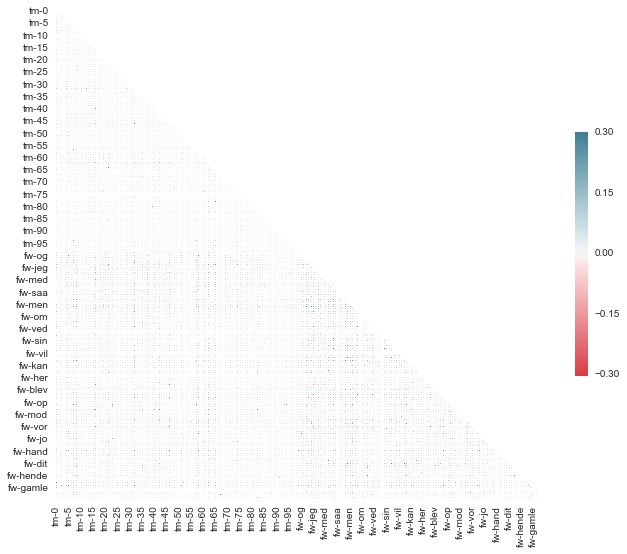

In [79]:
sns.set(style="white")

# Plot a correlation matrix
cormat_df = pd.DataFrame(compute_scaled, columns = col_labels)

# Compute the correlation matrix
corr = cormat_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            cmap=cmap, 
            vmax=.3,
            square=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax=ax)
plt.savefig('figures/correlations.png', dpi=300)

In [80]:
# Reduce dimensionality
num_dims = 10

pca = PCA(n_components=num_dims)
compute_reduced = pca.fit_transform(compute_scaled)
for i in range(1,num_dims+1):
    pctvar = sum(pca.explained_variance_ratio_[0:i])
    print("(%s) Sum of variance explained: %s" % (i, pctvar))

(1) Sum of variance explained: 0.0299227387153
(2) Sum of variance explained: 0.0504376026556
(3) Sum of variance explained: 0.0679185673865
(4) Sum of variance explained: 0.0832350154991
(5) Sum of variance explained: 0.097998556125
(6) Sum of variance explained: 0.110331575064
(7) Sum of variance explained: 0.121955816262
(8) Sum of variance explained: 0.132940230298
(9) Sum of variance explained: 0.143036232807
(10) Sum of variance explained: 0.152387489358


In [81]:
print(np.mean(compute_reduced), np.std(compute_reduced))
# Rescale
compute_reduced = scaler.fit_transform(compute_reduced)
print(np.mean(compute_reduced), np.std(compute_reduced))

-5.23787536673e-17 1.74578056673
1.45496537965e-18 1.0


In [82]:
compute_reduced.shape

(6837, 10)

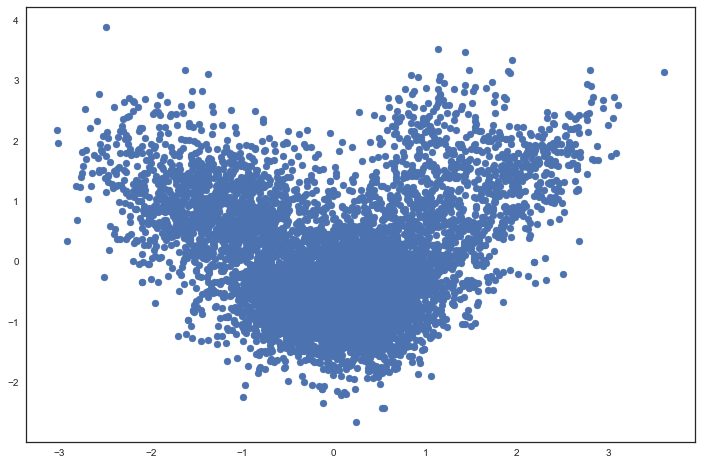

In [83]:
plt.scatter(compute_reduced.T[0], compute_reduced.T[1])

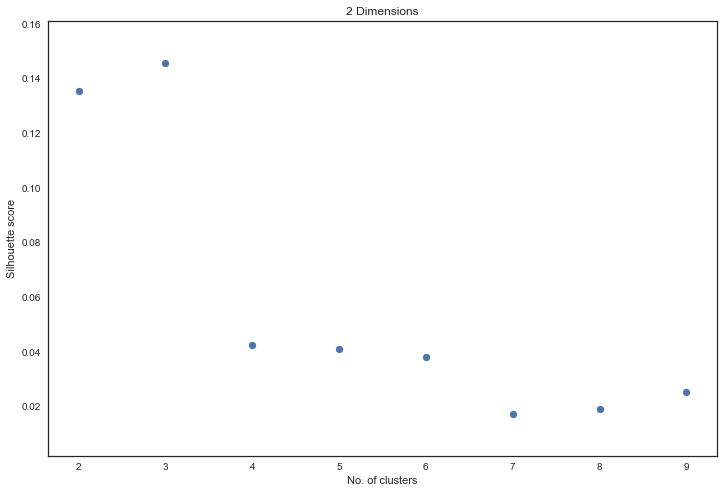

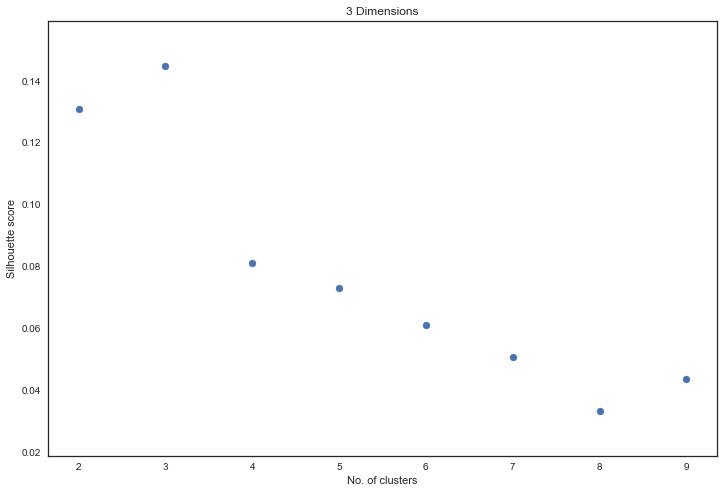

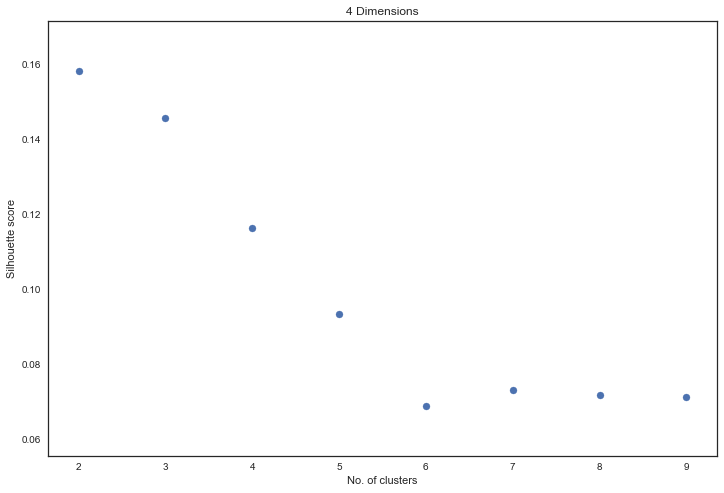

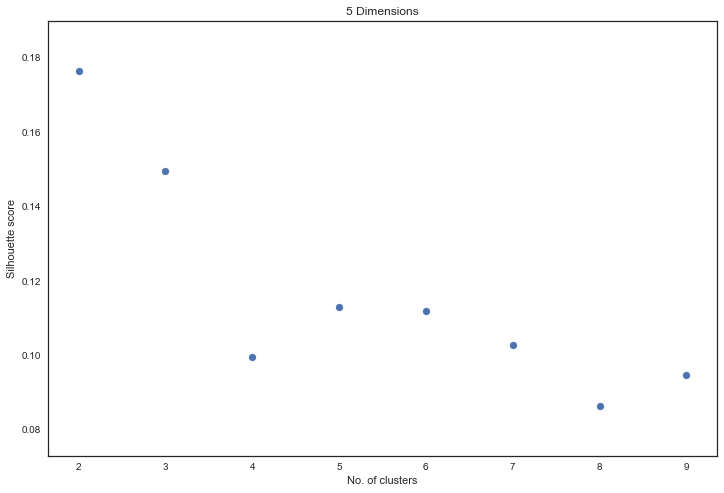

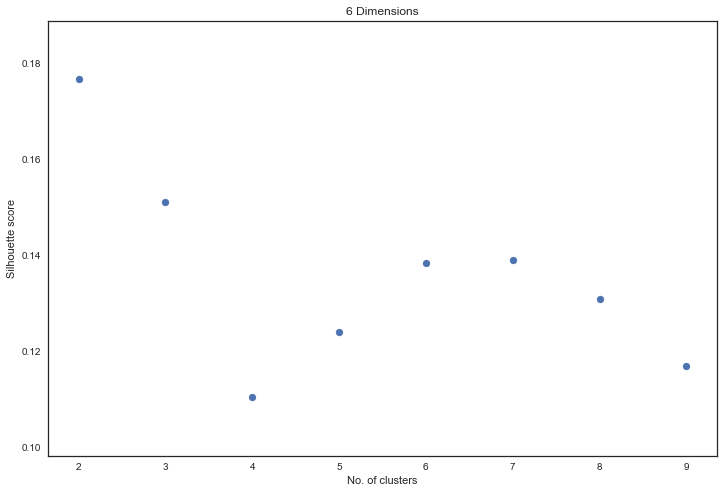

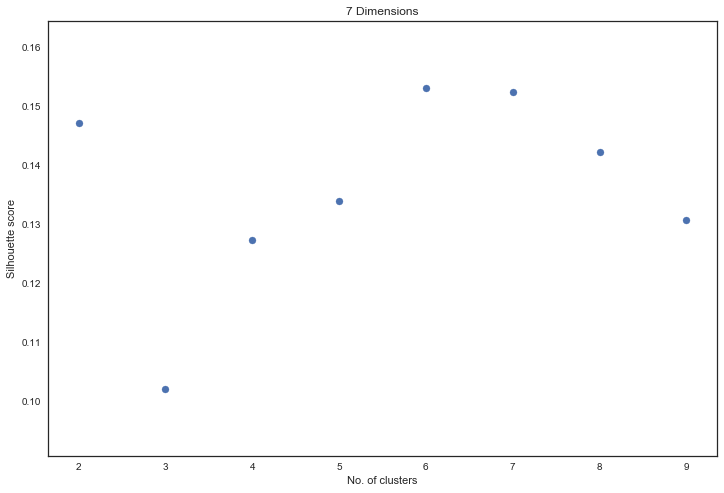

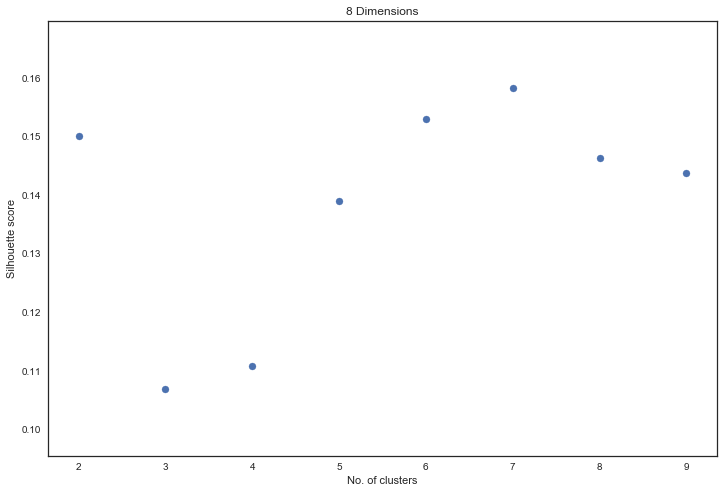

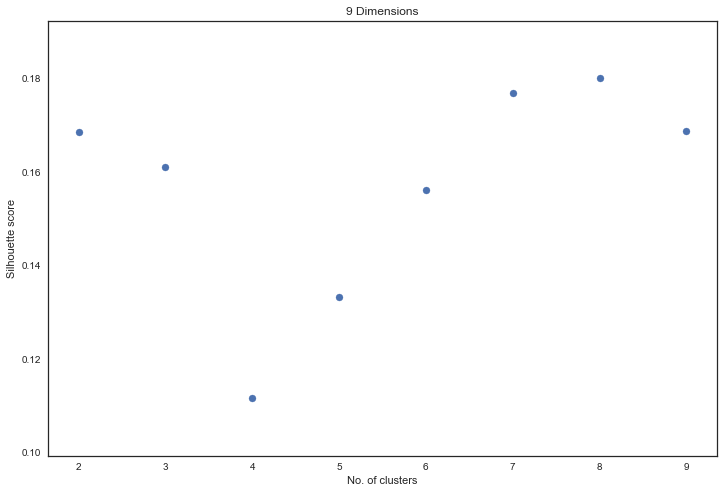

CPU times: user 1min 39s, sys: 20.5 s, total: 2min
Wall time: 1min 57s


In [84]:
%%time

# Calculate silhouette scores for k-means clustering, varying number of clusters and data dimensions
for j in range(2,num_dims):
    numbers_clusters = []
    silhouette_scores = []
    for i in range(2,10):
        num_clusters = i
        km = KMeans(n_clusters=num_clusters)
        km.fit(compute_reduced[:,:j])
        labels = km.labels_
        numbers_clusters.append(num_clusters)
        silhouette_scores.append(silhouette_score(compute_reduced, labels))
    plt.scatter(numbers_clusters, silhouette_scores)
    plt.title(str(j)+" Dimensions")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhouette score")
    plt.show()

In [85]:
# Let's try 4 clusters in three dimensions.
num_clusters = 9
use_dims = 8
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(compute_reduced[:,:use_dims])
clusters = km.labels_.tolist()
cluster_data = source_data.iloc[:, range(md_cols)]
cluster_data['km']  = pd.Series(clusters, index=source_data.index, name='km')
cluster_data['PC1'] = pd.Series(compute_reduced.T[0], index=source_data.index, name='PC1')
cluster_data['PC2'] = pd.Series(compute_reduced.T[1], index=source_data.index, name='PC2')
cluster_data['PC3'] = pd.Series(compute_reduced.T[2], index=source_data.index, name='PC3')

In [86]:
cluster_data.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
claussen04val_workid58330       Sophus Claussen   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
claussen04val_workid58330                   I en frugthave   

                                            volume  birth  death  wordcount  \
file_id                                                                       
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0   
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0   
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0   
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0   
claussen04val_workid58330                 Lyrik II   1865   1931      224.0   

                             km       PC1       PC2       PC3  
file_id                                                        
grundtvig11val_workid118888   2 -0.826482 -0.752255 -0.243293  
stuckenberg02_workid77235     6 -0.345388 -1.398198  0.141716  
hauch03val_workid83908        2 -0.145745  0.555035  1.783231  
plough01_workid56672          6 -0.096049 -1.323817 -0.983291  
claussen04val_workid58330     6 -0.383592 -1.303804  1.864872

In [87]:
cluster_data.describe()

birth       death    wordcount           km           PC1  \
count  6837.000000  6837.00000  6837.000000  6837.000000  6.837000e+03   
mean   1782.158842  1846.98669   805.230657     3.480328 -2.003825e-17   
std      84.719538    83.77847  1356.886230     2.592372  1.000073e+00   
min    1485.000000  1534.00000   100.000000     0.000000 -3.032972e+00   
25%    1743.000000  1785.00000   192.000000     1.000000 -6.600374e-01   
50%    1798.000000  1872.00000   339.000000     3.000000  5.051065e-02   
75%    1861.000000  1908.00000   722.000000     6.000000  5.977367e-01   
max    1912.000000  1938.00000  9999.000000     8.000000  3.616892e+00   

                PC2           PC3  
count  6.837000e+03  6.837000e+03  
mean  -2.013568e-17 -5.521074e-18  
std    1.000073e+00  1.000073e+00  
min   -2.653674e+00 -4.083306e+00  
25%   -7.592570e-01 -6.247431e-01  
50%   -2.159488e-01 -6.311957e-02  
75%    6.845316e-01  6.552589e-01  
max    3.886622e+00  5.665792e+00

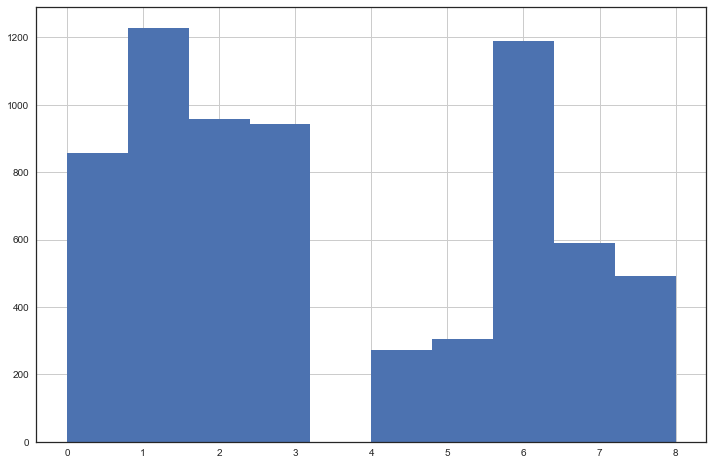

In [88]:
cluster_data.km.hist()

In [89]:
# Construct legend entries
if num_clusters <= 6:
    colors = ['steelblue', 'darkred', 'gold', 'darkgreen', 'purple', 'lightblue']
else:
    colors = []
    for i in range(num_clusters):
        colors.append(cm.spectral((i+0.1)/(num_clusters-0.9)))

markers = num_clusters*['o']

grouped_dates = cluster_data['birth'].groupby(cluster_data['km'])
avg_date = cluster_data['birth'].mean()
cluster_newness = list(grouped_dates.mean() - avg_date)

legend_labels = []
for i in range(num_clusters):
    legend_labels.append(str(i)+': '+
                         str(round(cluster_newness[i],1))+' yrs, '+
                         str(cluster_data['km'].value_counts()[i])+' vols')
legend_entries = []
for i in range(len(legend_labels)):
    legend_entries.append(mpatches.Patch(color=colors[i], label=legend_labels[i], alpha = .75))

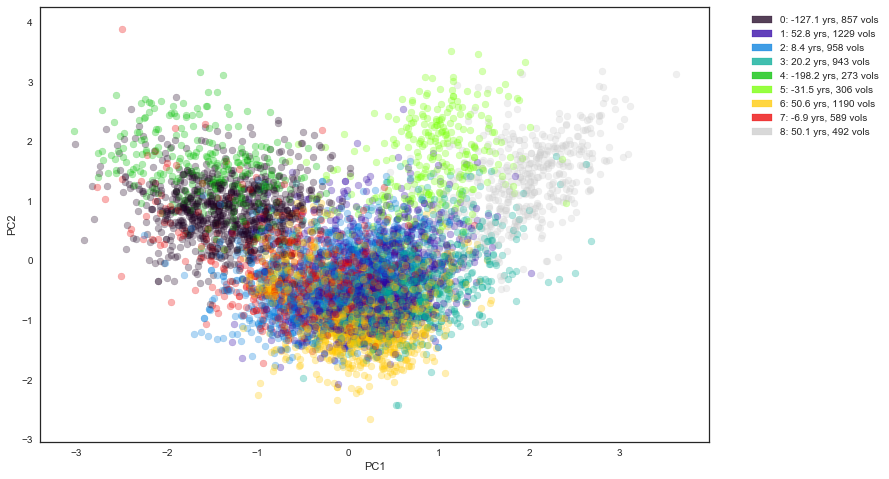

In [90]:
# Plot clustering results
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(compute_reduced)):
#for i in range(500):
    ax.scatter(compute_reduced[i][0], compute_reduced[i][1], \
               c=colors[clusters[i]], alpha=0.3, marker=markers[clusters[i]])
ax.legend(handles=legend_entries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('PC2')
plt.xlabel('PC1')
fig.savefig(os.path.join(figDir, 'clusters.png'), dpi=300, bbox_inches='tight')

In [92]:
# Interactive plot
l = []
y = []
# Setting colors for plot.
N = num_clusters
if N <= 6:
    c = colors
else:
    c = ['darkgrey', 'purple', 'steelblue', 'lightblue', 'darkgreen', 'lightgreen', 'orange', 'red', 'lightgrey']

plotly_labels = cluster_data.author.str.cat(cluster_data.birth.astype(str), sep=',')\
.str.cat(cluster_data.death.astype(str), sep='-')\
.str.cat(cluster_data.title, sep='. ')\
.str.cat(cluster_data.wordcount.astype(str), sep='. ')

for i in range(int(N)):
    y.append(i)
    trace0= go.Scatter(
        x= cluster_data[cluster_data.km == i]['PC1'],
        y= cluster_data[cluster_data.km == i]['PC2'],
        mode= 'markers',
        marker= dict(size= 14,
                    line= dict(width=0),
                    color= c[i],
                    opacity= 0.3
                   ),name= y[i],
        text= plotly_labels # The hover text goes here... 
    )
    l.append(trace0);

layout= go.Layout(
    title= 'Clusters',
    hovermode= 'closest',
    xaxis= dict(
        title= 'PC1',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'PC2',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)
fig= go.Figure(data=l, layout=layout)
py.iplot(fig)